Решение задачи с помощью алгоритмов классического машинного обучения

## Импорты

In [1]:
import os
import typing
from tqdm import tqdm

import pandas as pd
import json

import numpy as np

In [2]:
from datetime import datetime

## Классы

In [3]:
class DataFilePaths:
    def __init__(self, testcase_path: str):
        self.testcase_path = testcase_path

    def localization(self):
        return os.path.join(self.testcase_path, 'localization.csv')

    def control(self):
        return os.path.join(self.testcase_path, 'control.csv')

    def metadata(self):
        return os.path.join(self.testcase_path, 'metadata.json')

    # exists only for test_dataset
    def requested_stamps(self):
        return os.path.join(self.testcase_path, 'requested_stamps.csv')

## Функции

In [4]:
# Load all ids of a dataset

def read_testcase_ids(dataset_path: str):
    ids = [int(case_id) for case_id in os.listdir(dataset_path) if os.path.isdir(os.path.join(dataset_path, case_id))]
    return ids

In [5]:
def read_localization(localization_path: str):
    return pd.read_csv(localization_path)

def read_control(control_path):
    return pd.read_csv(control_path)

def read_metadata(metadata_path: str):
    with open(metadata_path, 'r') as f:
        data = json.load(f)
    return data

def read_requested_stamps(requested_stamps_path: str):
    return pd.read_csv(requested_stamps_path)

def read_testcase(dataset_path: str, testcase_id: str, is_test: bool = False):
    testcase_path = os.path.join(dataset_path, str(testcase_id))
    data_file_paths = DataFilePaths(testcase_path)

    testcase_data = {}
    testcase_data['localization'] = read_localization(data_file_paths.localization())
    testcase_data['control'] = read_control(data_file_paths.control())
    testcase_data['metadata'] = read_metadata(data_file_paths.metadata())
    if is_test:
        testcase_data['requested_stamps'] = read_requested_stamps(data_file_paths.requested_stamps())

    return testcase_data

In [6]:
def read_testcases(dataset_path: str, is_test: bool = False,
                   testcase_ids: typing.Iterable[int] = None,
                   amount: int | None = None):
    result = {}
    if testcase_ids is None:
        if amount is None:
            testcase_ids = read_testcase_ids(dataset_path)
        else:
            testcase_ids = read_testcase_ids(dataset_path)[:amount]

    for testcase_id in tqdm(testcase_ids):
        testcase = read_testcase(dataset_path, testcase_id, is_test=is_test)
        result[testcase_id] = testcase
    return result

## Данные

In [9]:
# Пути до датасетов

ROOT_DATA_FOLDER = "../"

TRAIN_DATASET_PATH = os.path.join(ROOT_DATA_FOLDER, "YaCupTrain")
TEST_DATASET_PATH = os.path.join(ROOT_DATA_FOLDER, "YaCupTest")

In [10]:
# Чтение train dataset

train_dataset = read_testcases(TRAIN_DATASET_PATH, amount=10000)
len(train_dataset)

100%|██████████| 10000/10000 [00:35<00:00, 283.33it/s]


10000

In [49]:
# Чтение test dataset

test_dataset = read_testcases(TEST_DATASET_PATH, is_test=True, amount=None)
len(test_dataset)

100%|██████████| 8000/8000 [00:22<00:00, 360.46it/s]


8000

## Сборка всех фич в один датасет

In [50]:
# Функция для конвертации даты в время года (зима, весна, лето, осень)
def get_season(date):
    month = date.month
    if month in (12, 1, 2):
        return 'зима'
    elif month in (3, 4, 5):
        return 'весна'
    elif month in (6, 7, 8):
        return 'лето'
    else:
        return 'осень'

In [13]:
# Функция для записи создания датасета с указанием дополнительных фич + все id сцен собираются в один датасет
def prepare_train_dataset(dataset):
    # Создание общего датасета
    all_data = {"case_id": [], "season": [], "vehicle_model": [], "vehicle_model_modification": [],
                "stamp_ns": [], "x": [], "y": [], "z": [],
                "roll": [], "pitch": [], "yaw": [], "x_shift": [], "y_shift": [],
                "z_shift": [], "roll_shift": [], "pitch_shift": [], "yaw_shift": [],
                }

    for key in tqdm(dataset.keys()):
        # Данные для case_id
        key = int(key)
        cur = dataset[key]['localization']
        key_vals = [key] * len(cur)

        # Сдвиг по осям X, Y, Z
        x_shifts = np.ediff1d(cur['x'].values, to_begin=0)
        y_shifts = np.ediff1d(cur['y'].values, to_begin=0)
        z_shifts = np.ediff1d(cur['z'].values, to_begin=0)
        # Изменение угла поворта по осям roll, pitch, yaw
        roll_shifts = np.ediff1d(cur['roll'].values, to_begin=0)
        pitch_shifts = np.ediff1d(cur['pitch'].values, to_begin=0)
        yaw_shifts = np.ediff1d(cur['yaw'].values, to_begin=0)


        # Получение метаданных сцены
        meta = train_dataset[key]['metadata']
        ride_date = datetime.strptime(meta['ride_date'], '%Y-%m-%d')
        # Вычисление сезона года из даты
        ride_date = get_season(ride_date)
        ride_date_vals = [ride_date] * len(cur)
        vehicle_model = int(meta['vehicle_model'])
        vehicle_model_vals = [vehicle_model] * len(cur)
        vehicle_model_modification = int(meta['vehicle_model_modification'])
        vehicle_model_modification_vals = [vehicle_model_modification] * len(cur)

        all_data['case_id'].extend(key_vals)
        all_data['x_shift'].extend(x_shifts)
        all_data['y_shift'].extend(y_shifts)
        all_data['z_shift'].extend(z_shifts)
        all_data['roll_shift'].extend(roll_shifts)
        all_data['pitch_shift'].extend(pitch_shifts)
        all_data['yaw_shift'].extend(yaw_shifts)
        all_data['season'].extend(ride_date_vals)
        all_data['vehicle_model'].extend(vehicle_model_vals)
        all_data['vehicle_model_modification'].extend(vehicle_model_modification_vals)
        all_data['x'].extend(cur['x'])
        all_data['y'].extend(cur['y'])
        all_data['z'].extend(cur['z'])
        all_data['stamp_ns'].extend(cur['stamp_ns'])
        all_data['roll'].extend(cur['roll'])
        all_data['pitch'].extend(cur['pitch'])
        all_data['yaw'].extend(cur['yaw'])

    return all_data

In [51]:
# Функция для записи создания датасета с указанием дополнительных фич + все id сцен собираются в один датасет
def prepare_test_dataset(dataset):
    # Создание общего датасета
    all_data = {"case_id": [], "stamp_ns": [], "season": [],
                "vehicle_model": [], "vehicle_model_modification": []}
    for key in tqdm(dataset.keys()):
        # Данные для case_id
        cur = dataset[key]['requested_stamps']
        key = int(key)
        key_vals = [key] * len(cur)

        # Получение метаданных сцены
        meta = dataset[key]['metadata']
        ride_date = datetime.strptime(meta['ride_date'], '%Y-%m-%d')
        # Вычисление сезона года из даты
        ride_date = get_season(ride_date)
        ride_date_vals = [ride_date] * len(cur)
        vehicle_model = int(meta['vehicle_model'])
        vehicle_model_vals = [vehicle_model] * len(cur)
        vehicle_model_modification = int(meta['vehicle_model_modification'])
        vehicle_model_modification_vals = [vehicle_model_modification] * len(cur)

        all_data['case_id'].extend(key_vals)
        all_data['stamp_ns'].extend(cur['stamp_ns'])
        all_data['season'].extend(ride_date_vals)
        all_data['vehicle_model'].extend(vehicle_model_vals)
        all_data['vehicle_model_modification'].extend(vehicle_model_modification_vals)

    return all_data

### Создание новых датасетов с вынесением всей интересной информации в одной таблице

In [14]:
# Получение общего train dataset
train_dict = prepare_train_dataset(train_dataset)

df_train = pd.DataFrame(columns=['case_id', 'season', 'vehicle_model', 'vehicle_model_modification',
                                 'stamp_ns', 'x', 'y', 'z', 'roll', 'pitch', 'yaw', 'x_shift', 'y_shift',
                                 'z_shift', 'roll_shift', 'pitch_shift', 'yaw_shift'],
                        data=train_dict)

100%|██████████| 10000/10000 [00:11<00:00, 834.31it/s]


In [52]:
# Получение общего test dataset
test_dict = prepare_test_dataset(test_dataset)

# Сохранение данных в DataFrame
df_test = pd.DataFrame(columns=['case_id', 'season', 'vehicle_model', 'vehicle_model_modification',
                                'stamp_ns', 'x', 'y', 'yaw'],
                       data=test_dict)

100%|██████████| 8000/8000 [00:00<00:00, 15412.76it/s]


In [53]:
# Итоговые датасеты для обучения и предсказания
print("Датасет для обучения:")
print(df_train.head())
print("=============================================")
print("Датасет для предсказания:")
print(df_test.head())

Датасет для обучения:
   case_id season  vehicle_model  vehicle_model_modification   stamp_ns  \
0        0  весна              0                           0          0   
1        0  весна              0                           0   39989868   
2        0  весна              0                           0   79819886   
3        0  весна              0                           0  125154671   
4        0  весна              0                           0  159636974   

             x             y       yaw  
0 -4292.313705 -14527.266319 -1.936810  
1 -4292.489928 -14527.726083 -1.936858  
2 -4292.662729 -14528.183063 -1.936827  
3 -4292.862032 -14528.702952 -1.936894  
4 -4293.011898 -14529.097871 -1.936876  
Датасет для предсказания:
   case_id season  vehicle_model  vehicle_model_modification    stamp_ns    x  \
0        0  осень              1                           1  5000888836  NaN   
1        0  осень              1                           1  5040043013  NaN   
2        0  

In [15]:
# Запись полученного df_train в csv файл
df_train.to_csv("df_train.csv", header=True, index=False)

In [54]:
# Запись полученного df_test в csv файл
df_test.to_csv("df_test.csv", header=True, index=False)

## Обучение моделей

In [11]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error
from catboost import CatBoostRegressor
import matplotlib.pyplot as plt

In [16]:
# Чтение датасетов
df_train = pd.read_csv("df_train.csv")
# df_test = pd.read_csv("df_test.csv")

# Удаление лишних столбцов
df_train = df_train[['case_id', 'season', 'vehicle_model',
                     'vehicle_model_modification', 'stamp_ns',
                     'x', 'y', 'yaw']]

In [17]:
# Данные для обучения
X = df_train.drop(['x', 'y', 'yaw'], axis=1)
y_1 = df_train[['x']]
y_2 = df_train[['y']]
y_3 = df_train[['yaw']]

### Предсказание 'X'

In [18]:
# Разделение данных на обучающие и тестовые
# 1-ая модель
X_train, X_valid, y_train, y_valid = train_test_split(X, y_1, test_size=0.25, random_state=2024)

In [19]:
# Числовые переменные
X_nums = ['stamp_ns']
# Категориальные переменные
cat_features = ['case_id', 'season', 'vehicle_model', 'vehicle_model_modification']
# Зависимая переменная
y_col = ['x']

In [24]:
# Создание модели №1 для предсказания 'X'
model_1 = CatBoostRegressor(random_seed=2024, verbose=100, task_type="GPU",
                            cat_features=cat_features, loss_function="RMSE",
                            early_stopping_rounds=300, iterations=20000,
                            learning_rate=0.1)

In [25]:
# Обучение модели №1
model_1.fit(X_train, y_train, eval_set=(X_valid, y_valid))

0:	learn: 7048.7431855	test: 7055.0855193	best: 7055.0855193 (0)	total: 267ms	remaining: 1h 29m 8s
100:	learn: 5757.8719920	test: 5759.9664144	best: 5759.9664144 (100)	total: 7.66s	remaining: 25m 9s
200:	learn: 5690.7077091	test: 5692.4359671	best: 5692.4359671 (200)	total: 15.4s	remaining: 25m 12s
300:	learn: 5637.8044142	test: 5639.0999460	best: 5639.0999460 (300)	total: 23.3s	remaining: 25m 22s
400:	learn: 5597.7042074	test: 5598.7824539	best: 5598.7824539 (400)	total: 31.4s	remaining: 25m 33s
500:	learn: 5558.1993671	test: 5558.9210819	best: 5558.9210819 (500)	total: 39.7s	remaining: 25m 43s
600:	learn: 5526.1297008	test: 5526.4934319	best: 5526.4934319 (600)	total: 47.8s	remaining: 25m 42s
700:	learn: 5494.2971461	test: 5494.1702169	best: 5494.1702169 (700)	total: 55.8s	remaining: 25m 35s
800:	learn: 5456.6726345	test: 5455.8062668	best: 5455.8062668 (800)	total: 1m 4s	remaining: 25m 40s
900:	learn: 5415.3454505	test: 5414.1083328	best: 5414.1083328 (900)	total: 1m 12s	remaining: 

In [26]:
print(f"Лучшее качество модели получено на {model_1.best_iteration_} итерации")
print(f"RMSE на обучающих данных = {model_1.best_score_['learn']['RMSE']:.2f}")
print(f"RMSE на валидационных данных = {model_1.best_score_['validation']['RMSE']:.2f}")

Лучшее качество модели получено на 19999 итерации
RMSE на обучающих данных = 2340.42
RMSE на валидационных данных = 2332.64


In [27]:
# Метрики качества модели
preds = model_1.predict(X_valid)
result = r2_score(y_valid, preds)

print(f"R2 CatBoost модели = {result:.2f}")

# Точность модели с помощью расчета R2 метрики
preds = model_1.predict(X_valid)
result = mean_absolute_error(y_valid, preds)

print(f"MAE модели = {result:.2f}")

R2 CatBoost модели = 0.90
MAE модели = 1437.52


#### Сохранение и загрузка модели

In [28]:
model_1.save_model("../models/model_1.cbm")

In [52]:
model_1 = CatBoostRegressor().load_model("../models/model_1.cbm")

#### График обучения модели

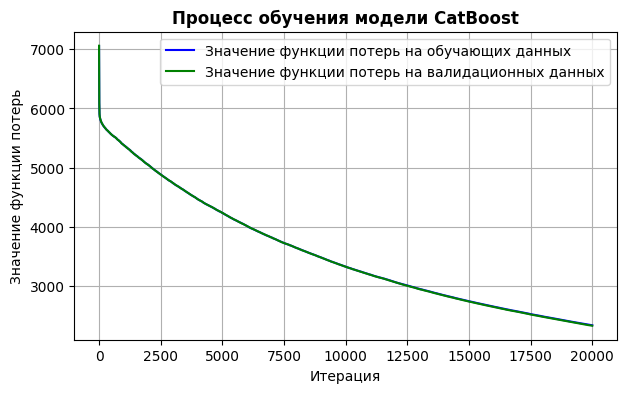

In [29]:
# Информация о значениях RMSE на обучающих данных и валидационных
evals_result = model_1.get_evals_result()
train_loss = evals_result['learn']["RMSE"]
test_loss = evals_result['validation']["RMSE"]


# Построение графика обучения модели CatBoost
iterations = np.arange(1, len(train_loss) + 1)

plt.figure(figsize=(7, 4))
plt.plot(iterations, train_loss, label='Значение функции потерь на обучающих данных', color='blue')
plt.plot(iterations, test_loss, label='Значение функции потерь на валидационных данных', color='green')
plt.xlabel('Итерация')
plt.ylabel('Значение функции потерь')
plt.title('Процесс обучения модели CatBoost', fontweight="bold")
plt.legend()
plt.grid()
# plt.savefig("../Images/Graphs/Training_Progress_CatBoost_Model_v2.png", dpi=199)
plt.show()

### Предсказание 'Y'

In [30]:
# Разделение данных на обучающие и тестовые
# 2-ая модель
X_train, X_valid, y_train, y_valid = train_test_split(X, y_2, test_size=0.25, random_state=2024)

In [31]:
# Числовые переменные
X_nums = ['stamp_ns']
# Категориальные переменные
cat_features = ['case_id', 'season', 'vehicle_model', 'vehicle_model_modification']
# Зависимая переменная
y_col = ['y']

In [33]:
# Создание модели №1 для предсказания 'X'
model_2 = CatBoostRegressor(random_seed=2024, verbose=100, task_type="GPU",
                            cat_features=cat_features, loss_function="RMSE",
                            early_stopping_rounds=300, iterations=12000,
                            learning_rate=0.1)

In [34]:
# Обучение модели №1
model_2.fit(X_train, y_train, eval_set=(X_valid, y_valid))

0:	learn: 15701.1697859	test: 15715.5380464	best: 15715.5380464 (0)	total: 336ms	remaining: 1h 7m 15s
100:	learn: 12713.7708585	test: 12722.6898399	best: 12722.6898399 (100)	total: 7.88s	remaining: 15m 28s
200:	learn: 12570.9361764	test: 12578.2833483	best: 12578.2833483 (200)	total: 15.7s	remaining: 15m 23s
300:	learn: 12475.1602605	test: 12480.8819795	best: 12480.8819795 (300)	total: 23.7s	remaining: 15m 21s
400:	learn: 12399.5388107	test: 12405.2785325	best: 12405.2785325 (400)	total: 32.1s	remaining: 15m 29s
500:	learn: 12314.9190100	test: 12318.1295458	best: 12318.1295458 (500)	total: 40.4s	remaining: 15m 26s
600:	learn: 12222.6370840	test: 12225.1982161	best: 12225.1982161 (600)	total: 49s	remaining: 15m 29s
700:	learn: 12138.4034484	test: 12139.6027778	best: 12139.6027778 (700)	total: 57.6s	remaining: 15m 29s
800:	learn: 12058.4542282	test: 12059.0827517	best: 12059.0827517 (800)	total: 1m 5s	remaining: 15m 22s
900:	learn: 11986.6691324	test: 11985.4202728	best: 11985.4202728 (9

In [35]:
print(f"Лучшее качество модели получено на {model_2.best_iteration_} итерации")
print(f"RMSE на обучающих данных = {model_2.best_score_['learn']['RMSE']:.2f}")
print(f"RMSE на валидационных данных = {model_2.best_score_['validation']['RMSE']:.2f}")

Лучшее качество модели получено на 11999 итерации
RMSE на обучающих данных = 6717.32
RMSE на валидационных данных = 6701.26


In [36]:
# Метрики качества модели
preds = model_2.predict(X_valid)
result = r2_score(y_valid, preds)

print(f"R2 CatBoost модели = {result:.2f}")

# Точность модели с помощью расчета R2 метрики
preds = model_2.predict(X_valid)
result = mean_absolute_error(y_valid, preds)

print(f"MAE модели = {result:.2f}")

R2 CatBoost модели = 0.83
MAE модели = 3624.46


#### Сохранение и загрузка модели

In [37]:
model_2.save_model("../models/model_2.cbm")

In [47]:
model_2 = CatBoostRegressor().load_model("../models/model_2.cbm")

#### График обучения модели

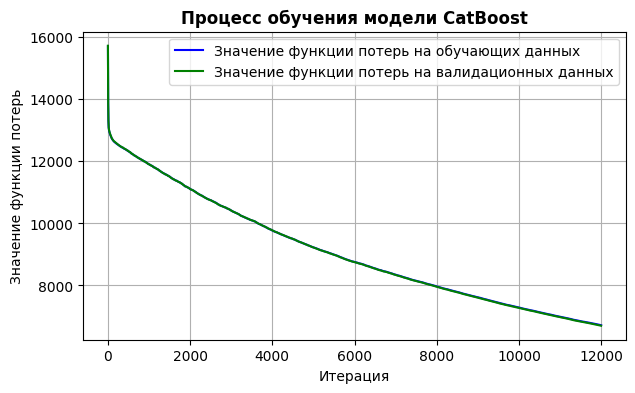

In [38]:
# Информация о значениях RMSE на обучающих данных и валидационных
evals_result = model_2.get_evals_result()
train_loss = evals_result['learn']["RMSE"]
test_loss = evals_result['validation']["RMSE"]


# Построение графика обучения модели CatBoost
iterations = np.arange(1, len(train_loss) + 1)

plt.figure(figsize=(7, 4))
plt.plot(iterations, train_loss, label='Значение функции потерь на обучающих данных', color='blue')
plt.plot(iterations, test_loss, label='Значение функции потерь на валидационных данных', color='green')
plt.xlabel('Итерация')
plt.ylabel('Значение функции потерь')
plt.title('Процесс обучения модели CatBoost', fontweight="bold")
plt.legend()
plt.grid()
# plt.savefig("../Images/Graphs/Training_Progress_CatBoost_Model_v2.png", dpi=199)
plt.show()

### Предсказание 'yaw'

In [39]:
# Разделение данных на обучающие и тестовые
# 2-ая модель
X_train, X_valid, y_train, y_valid = train_test_split(X, y_3, test_size=0.25, random_state=2024)

In [40]:
# Числовые переменные
X_nums = ['stamp_ns']
# Категориальные переменные
cat_features = ['case_id', 'season', 'vehicle_model', 'vehicle_model_modification']
# Зависимая переменная
y_col = ['yaw']

In [42]:
# Создание модели №1 для предсказания 'X'
model_3 = CatBoostRegressor(random_seed=2024, verbose=100, task_type="GPU",
                            cat_features=cat_features, loss_function="RMSE",
                            early_stopping_rounds=300, iterations=12000,
                            learning_rate=0.1)

In [43]:
# Обучение модели №1
model_3.fit(X_train, y_train, eval_set=(X_valid, y_valid))

0:	learn: 1.7227149	test: 1.7222039	best: 1.7222039 (0)	total: 273ms	remaining: 54m 33s
100:	learn: 0.9352903	test: 0.9305515	best: 0.9305515 (100)	total: 10.8s	remaining: 21m 16s
200:	learn: 0.9067906	test: 0.9017724	best: 0.9017724 (200)	total: 21.4s	remaining: 20m 56s
300:	learn: 0.8895182	test: 0.8842895	best: 0.8842895 (300)	total: 32.8s	remaining: 21m 14s
400:	learn: 0.8818441	test: 0.8765122	best: 0.8765122 (400)	total: 42.5s	remaining: 20m 29s
500:	learn: 0.8744596	test: 0.8689732	best: 0.8689732 (500)	total: 52.2s	remaining: 19m 57s
600:	learn: 0.8679681	test: 0.8623287	best: 0.8623287 (600)	total: 1m 1s	remaining: 19m 34s
700:	learn: 0.8630845	test: 0.8572963	best: 0.8572963 (700)	total: 1m 11s	remaining: 19m 15s
800:	learn: 0.8575746	test: 0.8516873	best: 0.8516873 (800)	total: 1m 21s	remaining: 18m 56s
900:	learn: 0.8520362	test: 0.8459466	best: 0.8459466 (900)	total: 1m 31s	remaining: 18m 42s
1000:	learn: 0.8463070	test: 0.8401221	best: 0.8401221 (1000)	total: 1m 41s	remai

In [44]:
print(f"Лучшее качество модели получено на {model_3.best_iteration_} итерации")
print(f"RMSE на обучающих данных = {model_3.best_score_['learn']['RMSE']:.2f}")
print(f"RMSE на валидационных данных = {model_3.best_score_['validation']['RMSE']:.2f}")

Лучшее качество модели получено на 11999 итерации
RMSE на обучающих данных = 0.63
RMSE на валидационных данных = 0.61


In [45]:
# Метрики качества модели
preds = model_3.predict(X_valid)
result = r2_score(y_valid, preds)

print(f"R2 CatBoost модели = {result:.2f}")

# Точность модели с помощью расчета R2 метрики
preds = model_3.predict(X_valid)
result = mean_absolute_error(y_valid, preds)

print(f"MAE модели = {result:.2f}")

R2 CatBoost модели = 0.89
MAE модели = 0.47


#### Сохранение и загрузка модели

In [46]:
model_3.save_model("../models/model_3.cbm")

In [ ]:
model_3 = CatBoostRegressor().load_model("../models/model_3.cbm")

#### График обучения модели

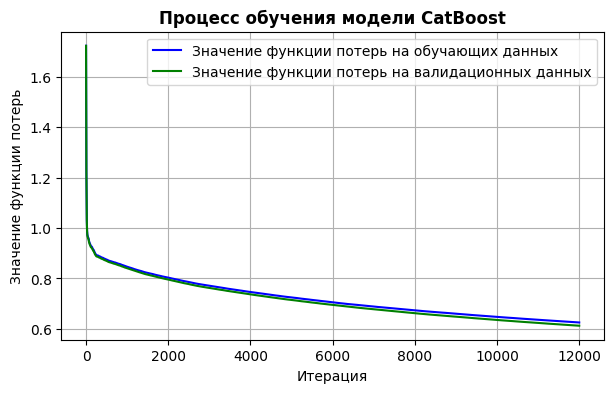

In [48]:
# Информация о значениях RMSE на обучающих данных и валидационных
evals_result = model_3.get_evals_result()
train_loss = evals_result['learn']["RMSE"]
test_loss = evals_result['validation']["RMSE"]


# Построение графика обучения модели CatBoost
iterations = np.arange(1, len(train_loss) + 1)

plt.figure(figsize=(7, 4))
plt.plot(iterations, train_loss, label='Значение функции потерь на обучающих данных', color='blue')
plt.plot(iterations, test_loss, label='Значение функции потерь на валидационных данных', color='green')
plt.xlabel('Итерация')
plt.ylabel('Значение функции потерь')
plt.title('Процесс обучения модели CatBoost', fontweight="bold")
plt.legend()
plt.grid()
# plt.savefig("../Images/Graphs/Training_Progress_CatBoost_Model_v2.png", dpi=199)
plt.show()

## Предсказание данных

In [57]:
df_test.head()

,case_id,season,vehicle_model,vehicle_model_modification,stamp_ns,x,y,yaw
0,0,осень,1,1,5000888836,NaN,NaN,NaN
1,0,осень,1,1,5040043013,NaN,NaN,NaN
2,0,осень,1,1,5079989560,NaN,NaN,NaN
3,0,осень,1,1,5120797471,NaN,NaN,NaN
4,0,осень,1,1,5165218288,NaN,NaN,NaN


In [60]:
# Предсказание 'X' 1-ой моделью
X_test = df_test.drop(['x', 'y', 'yaw'], axis=1)
x_preds = model_1.predict(X_test)
y_preds = model_2.predict(X_test)
yaw_preds = model_3.predict(X_test)

In [63]:
# Формирование predictions
predictions = df_test
predictions['x'] = x_preds
predictions['y'] = y_preds
predictions['yaw'] = yaw_preds

In [64]:
predictions.head()

,case_id,season,vehicle_model,vehicle_model_modification,stamp_ns,x,y,yaw
0,0,осень,1,1,5000888836,8598.27537,-80602.391069,-2.399783
1,0,осень,1,1,5040043013,8598.27537,-80602.391069,-2.399783
2,0,осень,1,1,5079989560,8598.27537,-80602.391069,-2.399783
3,0,осень,1,1,5120797471,8598.27537,-80602.391069,-2.399783
4,0,осень,1,1,5165218288,8598.27537,-80602.391069,-2.399783


In [66]:
# Удаление лишних столбцов
predictions = predictions.drop(['season', 'vehicle_model', 'vehicle_model_modification'], axis=1)

In [75]:
# Переименование столбца case_id в testcase_id
predictions.rename(columns={"case_id": "testcase_id"}, inplace=True)

In [77]:
# Запись в csv
predictions.to_csv("../predictions.csv", compression='gzip', index=False, header=True)